# Problem Statement

Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks. 

 

As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality.

 

With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied. To overcome this problem, the company has hired you as a data scientist to work on the forecasting problem. As part of your job role, you are tasked with building a forecasting model to forecast the daily sales for the next six weeks.

# Objective

1. Predict sales for 6 weeks in advance given the data.

2. Minimize the given metric as much as possible.

# 1) Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from sklearn.metrics import mean_squared_error

In [2]:
# import warnings
import warnings
warnings.filterwarnings('ignore')

# 2) Loading the datasets

In [3]:
# loading the train data
rossmann = pd.read_csv('train.csv',index_col='Store')
# loading the store details data
store = pd.read_csv('store.csv')

In [4]:
# displaying first five rows of train data
rossmann.head()

,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Store,,,,,,,,
1,5,31-07-2015,5263,555,1,1,0,1
2,5,31-07-2015,6064,625,1,1,0,1
3,5,31-07-2015,8314,821,1,1,0,1
4,5,31-07-2015,13995,1498,1,1,0,1
5,5,31-07-2015,4822,559,1,1,0,1


In [5]:
# displaying first five rows of store detail data
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
# checking info of train dataset
rossmann.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 1 to 1115
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   DayOfWeek      1017209 non-null  int64 
 1   Date           1017209 non-null  object
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 69.8+ MB


In [7]:
# converting Date column to datetime format
rossmann['Date']=pd.to_datetime(rossmann['Date'], errors='coerce',infer_datetime_format=True)

In [8]:
# checking shape of train data
rossmann.shape

(1017209, 8)

In [9]:
# describing train dataset
rossmann.describe()

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [10]:
# checking info of store dataset
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [11]:
# checking shape of store data
store.shape

(1115, 10)

In [12]:
# describing store dataset
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [13]:
# checking null value percentage in each column of train dataset
(rossmann.isnull().sum()*100/ len(rossmann)).sort_values(ascending=False)

DayOfWeek        0.0
Date             0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64

There are no null values in train data

In [14]:
# checking null value percentage in each column of store dataset
(store.isnull().sum()*100/ len(store)).sort_values(ascending=False)

Promo2SinceWeek              48.789238
Promo2SinceYear              48.789238
PromoInterval                48.789238
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
CompetitionDistance           0.269058
Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
Promo2                        0.000000
dtype: float64

There are null values in 6 columns of store data

Absence of promo values would mean that there are no promotions running on the store, we can impute that with zero

In [15]:
store['Promo2SinceWeek'].fillna(0, inplace=True)
store['Promo2SinceYear'].fillna(0, inplace=True)
store['PromoInterval'].fillna(0, inplace=True)

CompetitionDistance field has insignificant no. of null values, we will impute it with its mean

In [16]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean(), inplace=True)

In [17]:
# checking null value percentage in each column of store dataset
(store.isnull().sum()*100/ len(store)).sort_values(ascending=False)

CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.000000
Promo2                        0.000000
Promo2SinceWeek               0.000000
Promo2SinceYear               0.000000
PromoInterval                 0.000000
dtype: float64

CompetitionOpenSinceMonth and CompetitionOpenSinceYear has null values, we will handle them later after further analysis.

# 3) Data Cleaning

Analyzing the two columns in store dataset i.e CompetitionOpenSinceMonth and CompetitionOpenSinceYear which has null values

In [18]:
store['CompetitionOpenSinceYear'].isnull().sum()

354

In [19]:
store['CompetitionOpenSinceMonth'].isnull().sum()

354

We can see both CompetitionOpenSinceYear and CompetitionOpenSinceMonth is null for 352 stores 

We can impute them with zero

CompetitionOpenSinceMonth and CompetitionOpenSinceYear are null for 32% of stores, lets check their cases

In [20]:
store.loc[store.CompetitionOpenSinceMonth.isnull(),['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Store']]

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Store
11,1070.0,NaN,NaN,12
12,310.0,NaN,NaN,13
15,3270.0,NaN,NaN,16
18,3240.0,NaN,NaN,19
21,1040.0,NaN,NaN,22
...,...,...,...,...
1095,1130.0,NaN,NaN,1096
1099,540.0,NaN,NaN,1100
1112,9260.0,NaN,NaN,1113
1113,870.0,NaN,NaN,1114


In [21]:
store.loc[store.CompetitionOpenSinceYear.isnull(),['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Store']]

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Store
11,1070.0,NaN,NaN,12
12,310.0,NaN,NaN,13
15,3270.0,NaN,NaN,16
18,3240.0,NaN,NaN,19
21,1040.0,NaN,NaN,22
...,...,...,...,...
1095,1130.0,NaN,NaN,1096
1099,540.0,NaN,NaN,1100
1112,9260.0,NaN,NaN,1113
1113,870.0,NaN,NaN,1114


No data is available for competition store openings, let's impute them with zero

In [22]:
store.CompetitionOpenSinceYear.fillna(0,inplace=True)
store.CompetitionOpenSinceMonth.fillna(0,inplace=True)

In [23]:
# Checking null values
100*store.isnull().sum()/store.shape[0]

Store                        0.0
StoreType                    0.0
Assortment                   0.0
CompetitionDistance          0.0
CompetitionOpenSinceMonth    0.0
CompetitionOpenSinceYear     0.0
Promo2                       0.0
Promo2SinceWeek              0.0
Promo2SinceYear              0.0
PromoInterval                0.0
dtype: float64

All the Null values are handled , so we can proceed forward

# 4) Handling Outliers

Creating a function to plot boxplot of all numerical columns

In [24]:
def plot_boxplots(df):
    numerical_columns = df.select_dtypes(include=['int', 'float']).columns
    if len(numerical_columns) == 0:
        print("No numerical columns found in the DataFrame.")
        return
    for column in numerical_columns:
        plt.figure(figsize=(4, 3))
        df.boxplot(column=[column])
        plt.title(f'{column}')
        plt.ylabel('Values')
        plt.show()


Boxplot for all numerical columns in train dataset

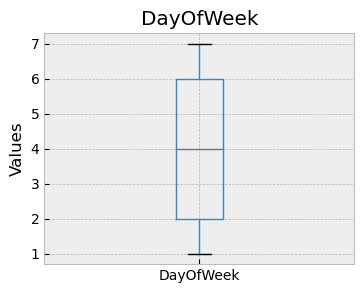

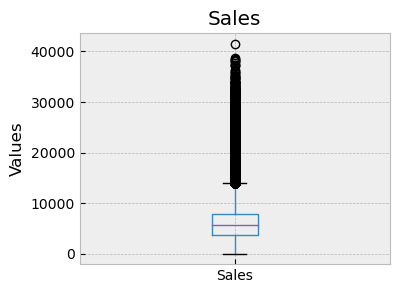

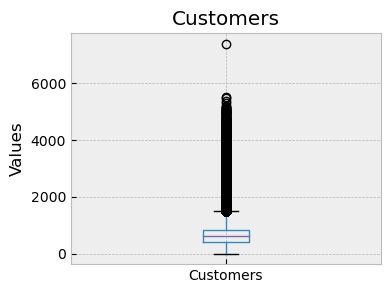

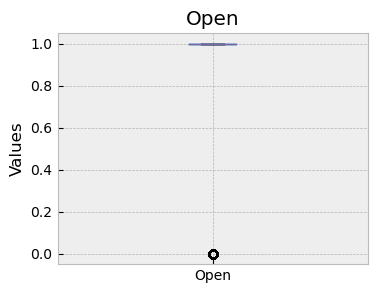

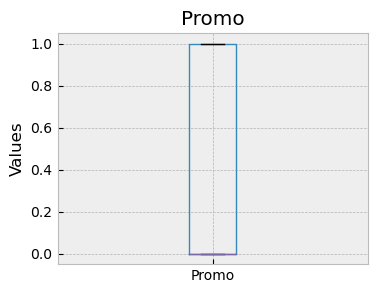

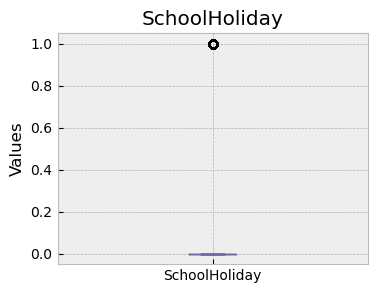

In [25]:
plot_boxplots(rossmann)

'Customers' is a numerical column which has clear outlier 

In [26]:
# Treating the outliers by using percentile method, keeping 99 percentile as the upper limit
rossmann = rossmann[rossmann.Customers < np.nanpercentile(rossmann.Customers,99)]

Boxplot for all numerical columns in store dataset

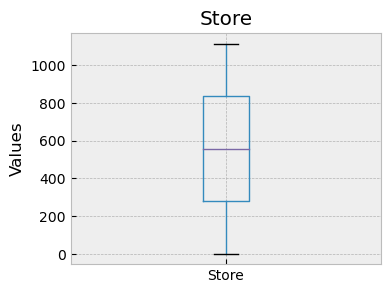

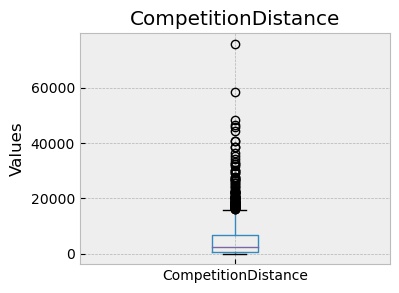

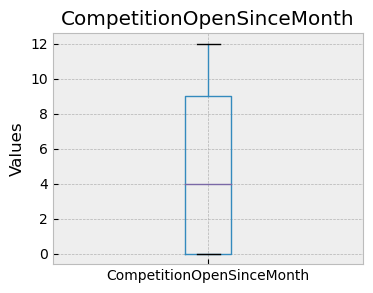

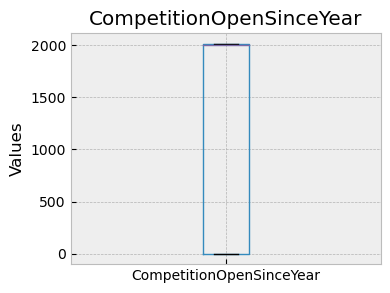

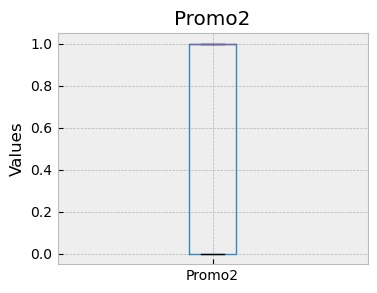

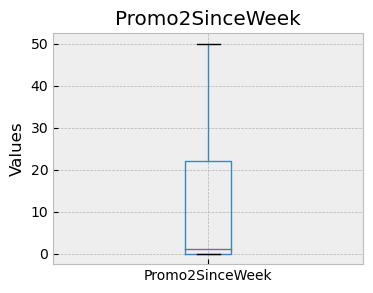

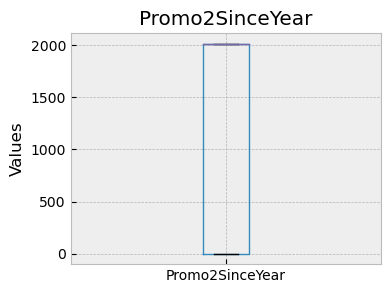

In [27]:
plot_boxplots(store)

For Competition distance, we would not need the values higher than the 99th percentile. We can cap the values having higher than 99th %ile to 99th %ile

In [28]:
# Treating the outliers by using percentile method, keeping 99 percentile as the upper limit
store = store[store.CompetitionDistance < np.nanpercentile(store.CompetitionDistance,99)]

# 5) Exploratory Data Analysis

### 5.1) Univariate Analysis

### For train data

In [29]:
# Creating function for plots

def CountPlot(features,df):
    cols=2
    rows = len(features)//cols +1
    fig = plt.figure(figsize=(16, rows*5))
    dataframe = df.copy()
    for plot, feature in enumerate(features):
        fig.add_subplot(rows,cols,plot+1)
        fig.tight_layout(h_pad=5, w_pad=5)
        dataframe[feature] = dataframe[feature].fillna('Missing')
        ax = sns.countplot(x=feature, data=dataframe,order = dataframe[feature].value_counts().index)
        plt.xticks(rotation = 90)
        plt.title("{}".format(feature))
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}'.format(height/len(dataframe) * 100),
                    ha="center")

In [30]:
# Train Data categoric variables
train_categorical_fields=['DayOfWeek','Open', 'Promo', 'StateHoliday', 'SchoolHoliday']

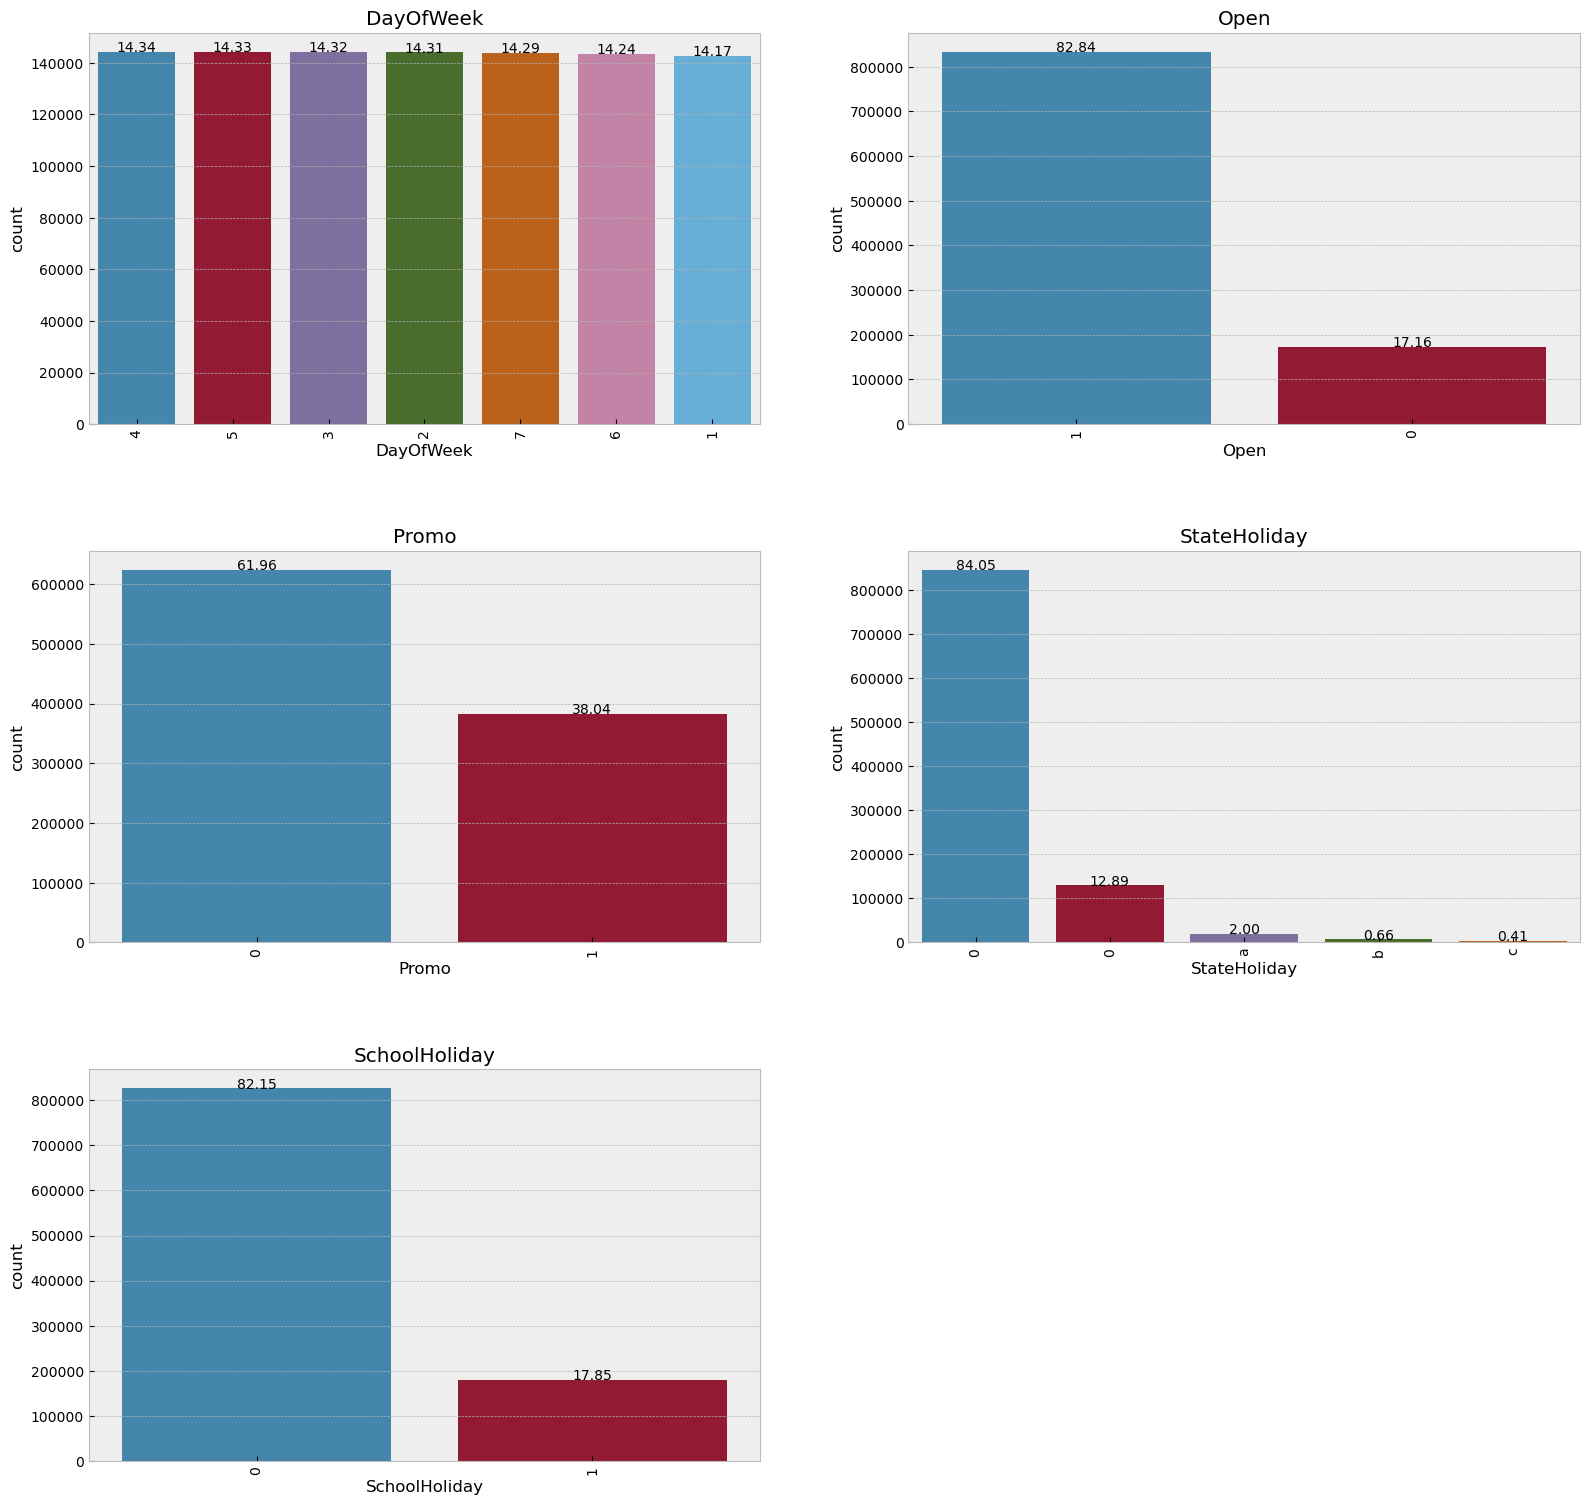

In [31]:
# Count plots for store data
CountPlot(train_categorical_fields,rossmann)

### Inference

- All days if the week have equal contribution.
- Stores are closed only on 17.33% data points.
- Promotion are only active on 38% records.

### For store data

In [32]:
# Store Data categorical fields
store_categorical_fields=['StoreType','Assortment','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval']

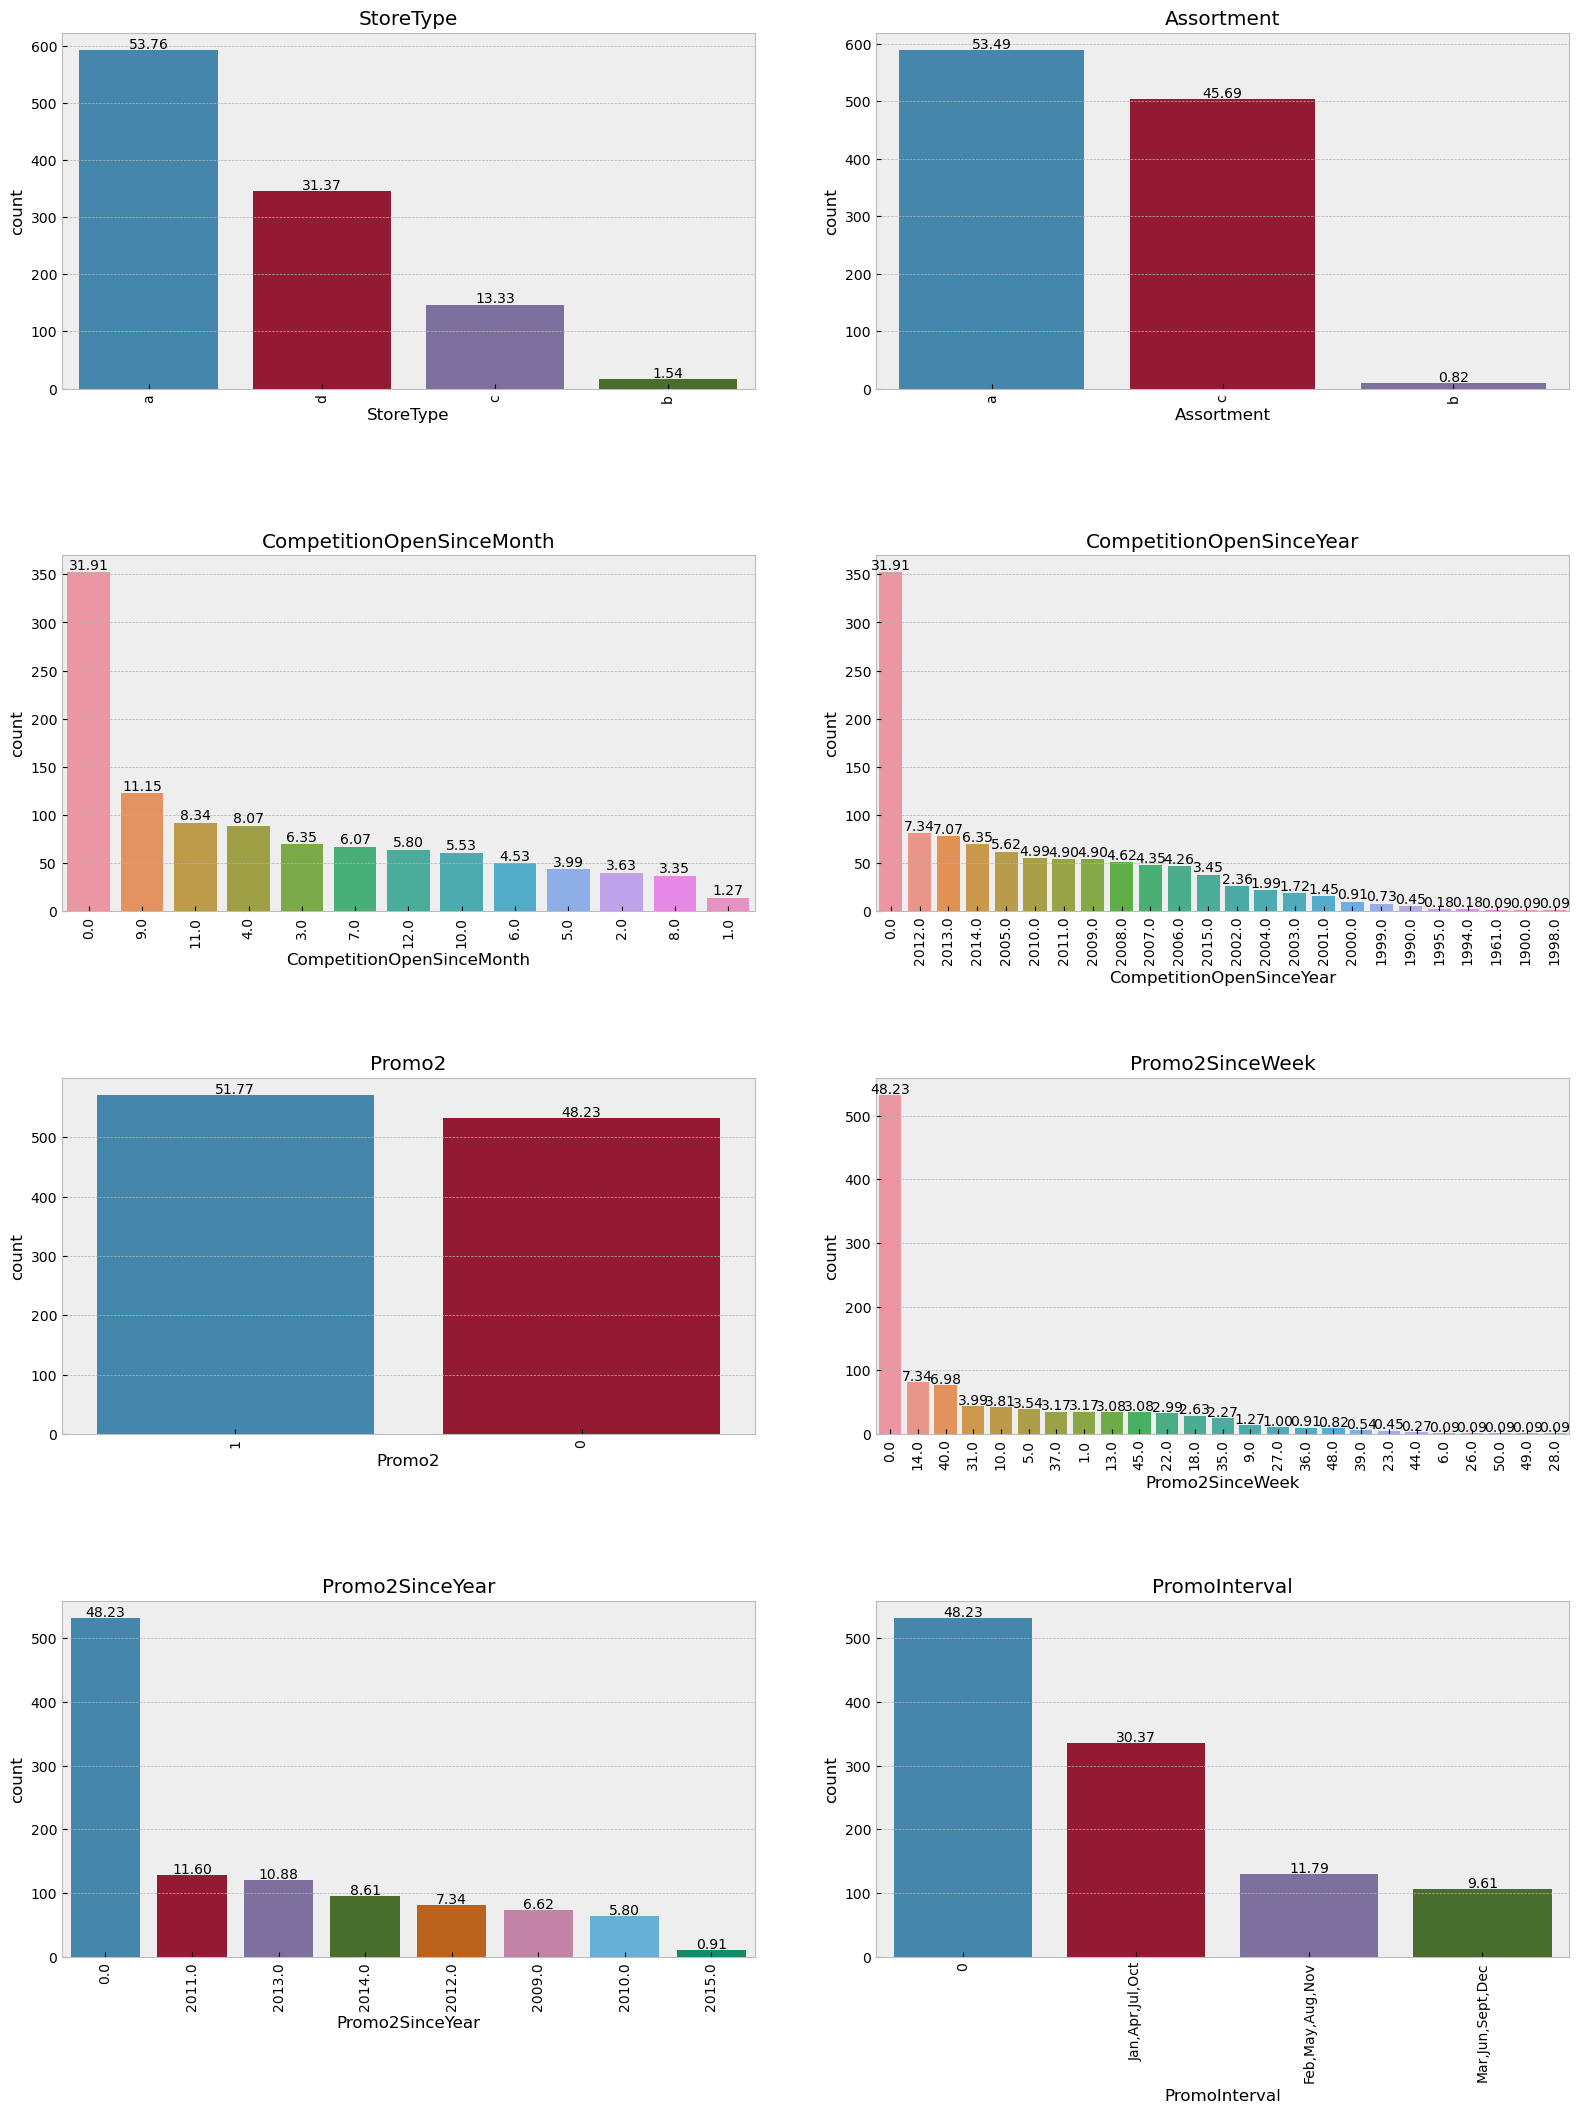

In [33]:
# Count plots for store data
CountPlot(store_categorical_fields,store)

### Inference

- Majority of the stores, almost 54% are type A stores.
- Majority of the stores have type A of the assortments (~ 54%), other type of assortments are low.
- Data for Competition is Null for 31% of the stores, meaning there is either no competition for those stores or the data is missing.
- 48% of the stores do not have promotions; Promo2 in the store.
- Promotions are concentrated in months of Jan, Apr, Jul, Oct months.

## Merging the datasets

In [34]:
merged_df = pd.merge(rossmann,store,how='inner',on='Store')
merged_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [35]:
# checking the shape of merged dataset
merged_df.shape

(995728, 18)

### 5.2) Bivariate Analysis

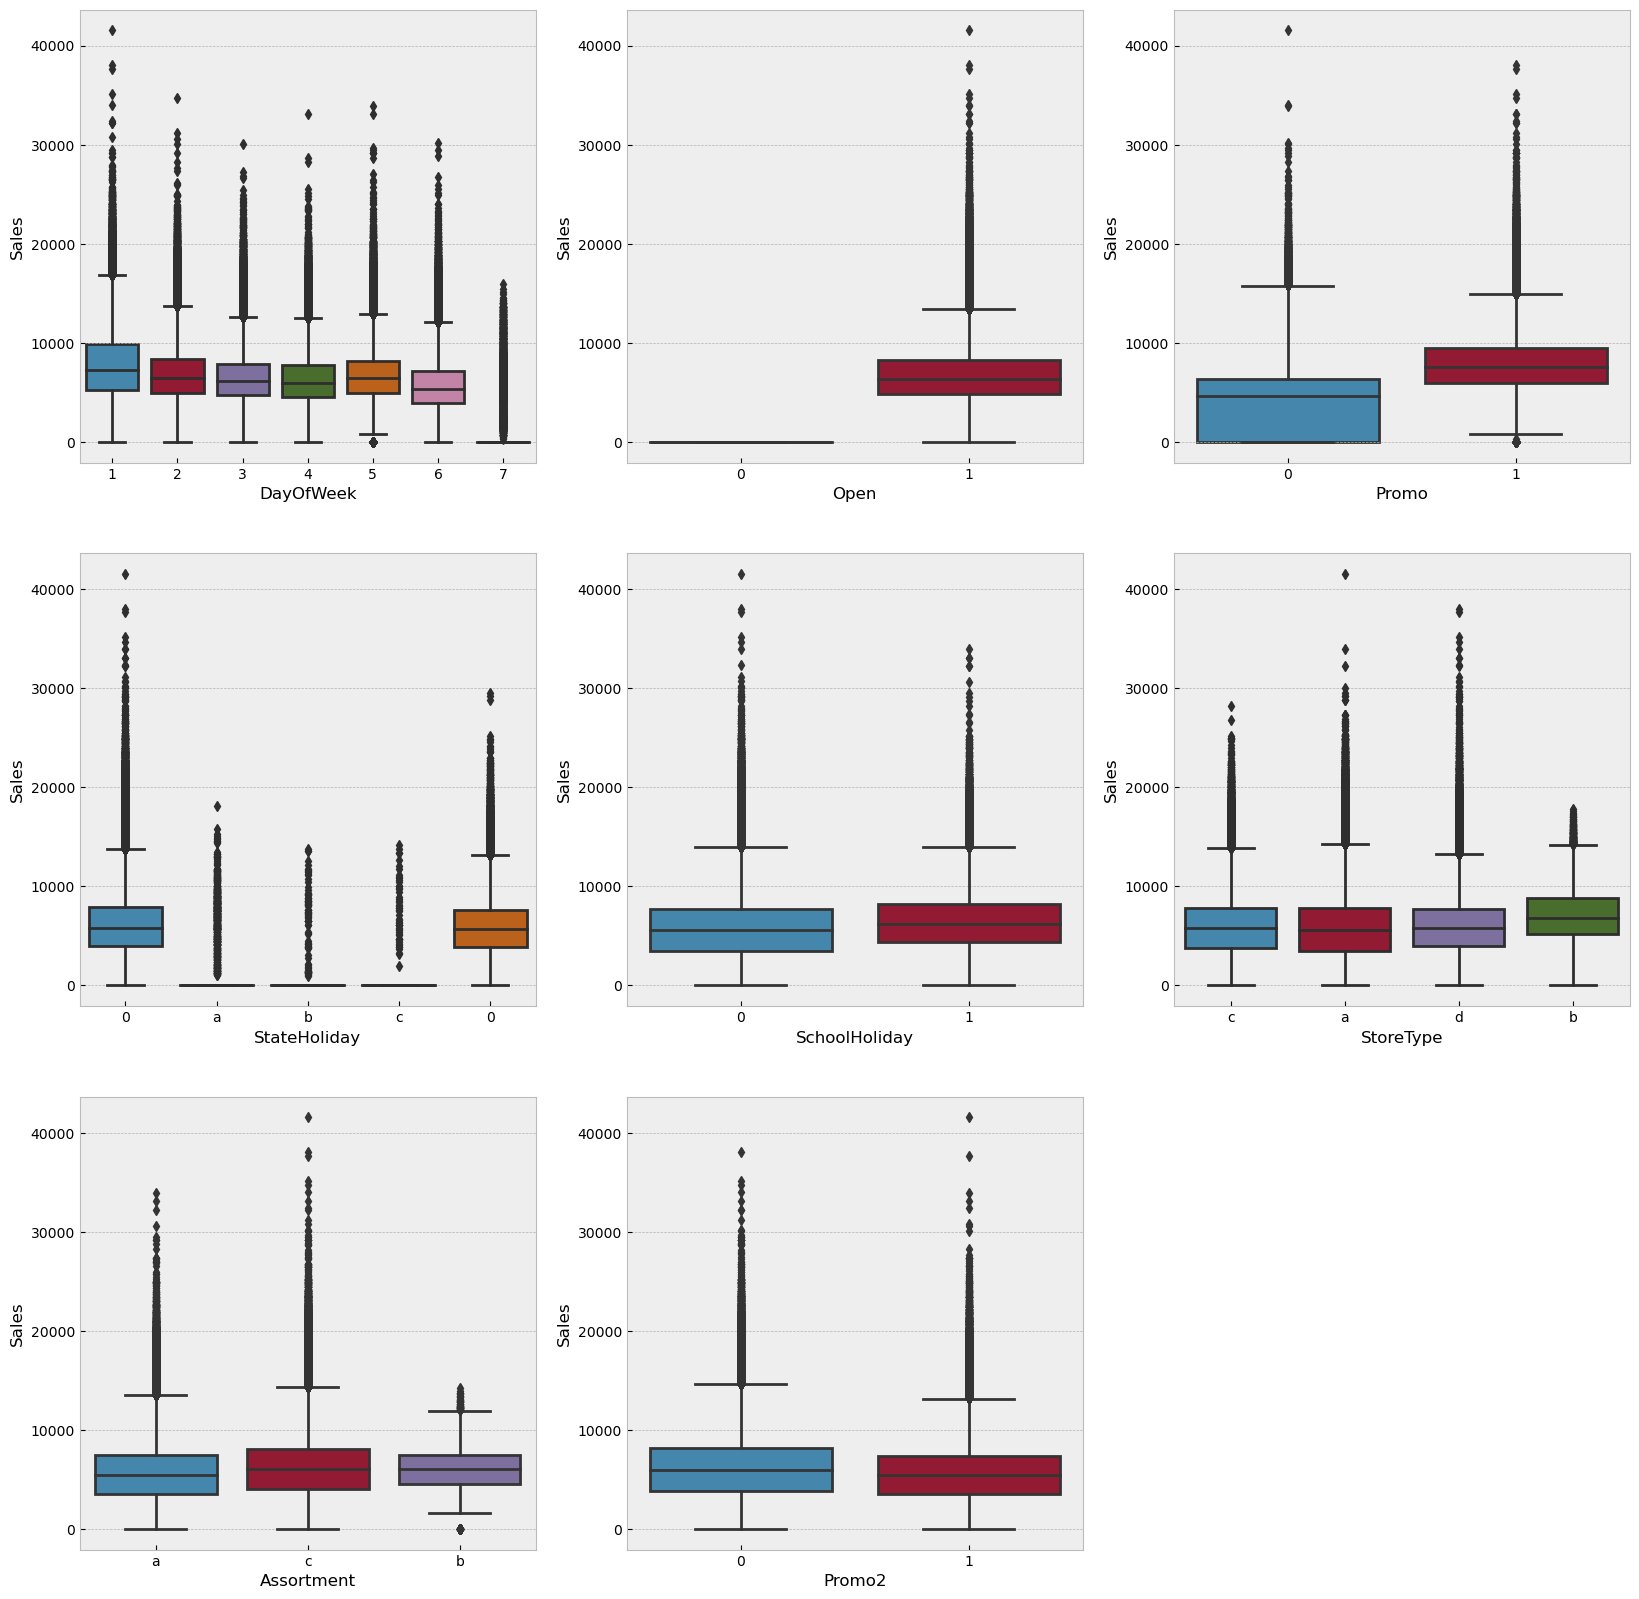

In [36]:
# Boxplots of attributes against Sales
plt.figure(figsize=(20, 20))
plt.subplot(3,3,1)
sns.boxplot(x = 'DayOfWeek', y = 'Sales', data = merged_df)
plt.subplot(3,3,2)
sns.boxplot(x = 'Open', y = 'Sales', data = merged_df)
plt.subplot(3,3,3)
sns.boxplot(x = 'Promo', y = 'Sales', data = merged_df)
plt.subplot(3,3,4)
sns.boxplot(x = 'StateHoliday', y = 'Sales', data = merged_df)
plt.subplot(3,3,5)
sns.boxplot(x = 'SchoolHoliday', y = 'Sales', data = merged_df)
plt.subplot(3,3,6)
sns.boxplot(x = 'StoreType', y = 'Sales', data = merged_df)
plt.subplot(3,3,7)
sns.boxplot(x = 'Assortment', y = 'Sales', data = merged_df)
plt.subplot(3,3,8)
sns.boxplot(x = 'Promo2', y = 'Sales', data = merged_df)
plt.show()

### Inferences

- Sales are higher on 1st, 2nd and 5th weekdays. Sales are very low on 7th weekday.
- Mean sales are almost same on everyday except 7th weekday.
- Mean sales are higher when promotion is 1.
- On state holidays, a, b and c, sales are low.
- School holidays don't seems to have impacted sales.
- Store type B has higher average of sales than other store types  but store A has highest sale value.
- Assortment type C has highest sale value.
- Promo2 does not seem to have much contribution to sales.

### 5.3) Scatter Plot Analysis

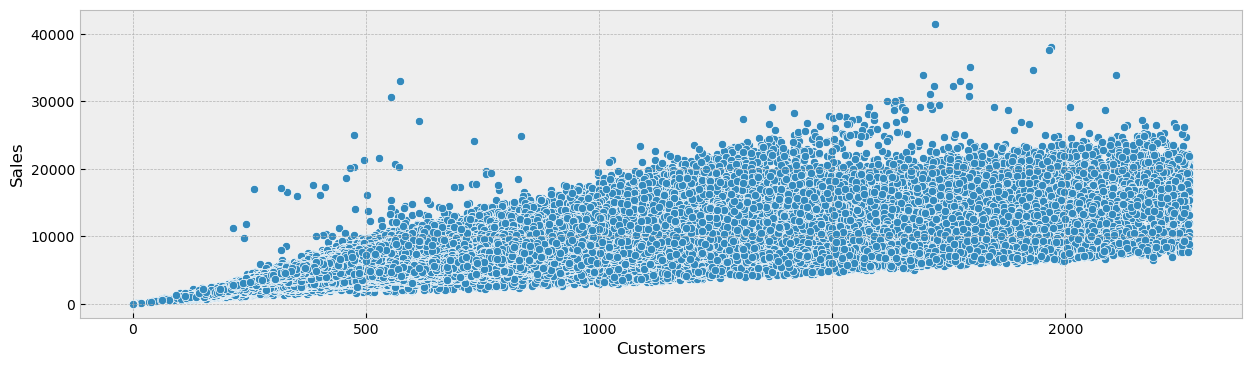

In [37]:
# scatterplot of Customer against sales 
plt.figure(figsize = (15,4))
sns.scatterplot(x='Customers', y='Sales',data=merged_df)
plt.show()

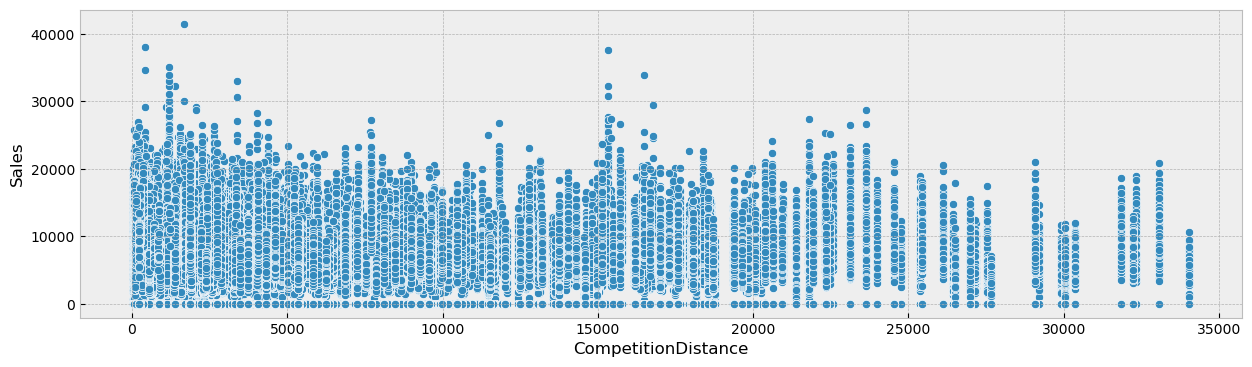

In [38]:
# scatterplot of CompetitionDistance against sales 
plt.figure(figsize = (15,4))
sns.scatterplot(x='CompetitionDistance', y='Sales',data=merged_df)
plt.show()

### Inference

- Sales is increasing as the number of customers are increasing.
- CompetitionDistance doesn't seem to have impacted sales

### 5.4) Multivariate Analysis

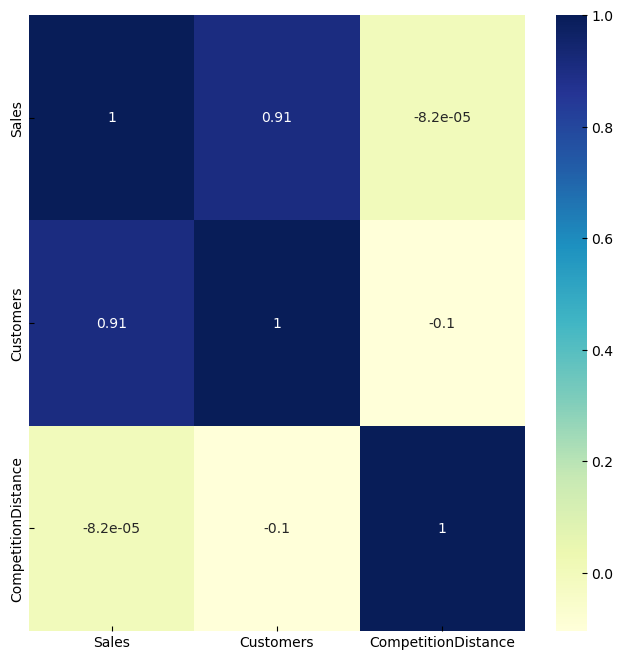

In [39]:
# Heatmap plot for numerical columns of merged data
plt.figure(figsize = (8,8))
cor = merged_df[['Sales','Customers','CompetitionDistance']].corr()
sns.heatmap(cor, annot=True,cmap='YlGnBu')
plt.show()

- Sales and Customer columns have high correlation and no other columns have insignificant correlation among them

# 6) Feature Engineering

### Creating dummy variables

In [40]:
dummy1 = pd.get_dummies(merged_df['DayOfWeek'], drop_first=True,prefix='DayOfWeek')
dummy2 = pd.get_dummies(merged_df['StoreType'], drop_first=True,prefix='StoreType')
dummy3 = pd.get_dummies(merged_df['Assortment'], drop_first=True,prefix='Assortment')
merged_df = pd.concat([merged_df,dummy1,dummy2,dummy3],axis=1)
merged_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,0,1,0,0,0,1,0,0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,0,1,0,0,0,0,1,0,0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,1,0,0,0,0,0,1,0,0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,0,0,0,0,0,0,1,0,0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,0,0,0,0,0,0,1,0,0,0


For Competition Data we can merge the infromation into single column

In [41]:
merged_df['CompetitionOpenSince'] = merged_df.CompetitionOpenSinceYear.astype(int).astype(str) + '-' + merged_df.CompetitionOpenSinceMonth.astype(int).astype(str) + '-01'
merged_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,CompetitionOpenSince
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,1,0,0,0,1,0,0,0,2008-9-01
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,1,0,0,0,0,1,0,0,0,2008-9-01
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,0,0,0,0,0,1,0,0,0,2008-9-01
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,0,0,0,0,0,1,0,0,0,2008-9-01
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,0,0,0,0,0,1,0,0,0,2008-9-01


In [42]:
merged_df.drop(columns=['CompetitionOpenSinceYear','CompetitionOpenSinceMonth'], axis=1,inplace=True)
merged_df.shape

(995728, 28)

We had 352 stores where competition opening dates were not available, the dates for CompetitionOpenSince for those stores needs to be imputed with null

In [43]:
# checking the competition dates whose dates are not available
merged_df.loc[merged_df.CompetitionOpenSince=='0-0-01','CompetitionOpenSince']

10361     0-0-01
10362     0-0-01
10363     0-0-01
10364     0-0-01
10365     0-0-01
           ...  
995717    0-0-01
995718    0-0-01
995719    0-0-01
995720    0-0-01
995721    0-0-01
Name: CompetitionOpenSince, Length: 316269, dtype: object

In [44]:
# imputing with null
merged_df.loc[merged_df.CompetitionOpenSince == '0-0-01', 'CompetitionOpenSince'] = np.nan

In [45]:
# checking datatypes
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 995728 entries, 0 to 995727
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Store                 995728 non-null  int64         
 1   DayOfWeek             995728 non-null  int64         
 2   Date                  995728 non-null  datetime64[ns]
 3   Sales                 995728 non-null  int64         
 4   Customers             995728 non-null  int64         
 5   Open                  995728 non-null  int64         
 6   Promo                 995728 non-null  int64         
 7   StateHoliday          995728 non-null  object        
 8   SchoolHoliday         995728 non-null  int64         
 9   StoreType             995728 non-null  object        
 10  Assortment            995728 non-null  object        
 11  CompetitionDistance   995728 non-null  float64       
 12  Promo2                995728 non-null  int64         
 13 

We saw that Promo2 columns didn't really contibuted in Sales , so we can drop them

In [46]:
# dropping the Promo2 columns and checking the merged dataset
merged_df.drop(['Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval'], axis=1, inplace=True)
merged_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,CompetitionOpenSince
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,1,0,0,0,1,0,0,0,2008-9-01
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,1,0,0,0,0,1,0,0,0,2008-9-01
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,0,0,0,0,0,1,0,0,0,2008-9-01
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,0,0,0,0,0,1,0,0,0,2008-9-01
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,0,0,0,0,0,1,0,0,0,2008-9-01


# 7) Time Series Analysis

From our earlier analysis, we have seen that increase in Customers directly translates to increase in Sales meaning customer counts are an endogenous variable for our predictions

In [47]:
# Grouping the data at a date level for analysis

merged_df = merged_df.set_index('Date')
merged_df_all=merged_df.groupby('Date').agg({'Sales': 'mean',
                                           'Customers':'mean', 
                                           'Promo': 'sum',
                                           'SchoolHoliday':'sum',
                                           'DayOfWeek_2':'mean',
                                           'DayOfWeek_3':'mean',
                                           'DayOfWeek_4':'mean',
                                           'DayOfWeek_5':'mean',
                                           'DayOfWeek_6':'mean',
                                           'DayOfWeek_7':'mean'})
merged_df_all.head()

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,
2013-01-01,62.911818,12.944545,0,1100,1.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,6119.903758,726.670027,0,1091,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03,5631.419325,670.728350,0,1023,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-04,5888.834703,687.430137,0,1021,0.0,0.0,0.0,1.0,0.0,0.0
2013-01-05,5249.642269,600.418115,0,112,0.0,0.0,0.0,0.0,1.0,0.0


Creating a function to plot time-series graphs

In [48]:
def timeseries_plot(series,c):
    fig = plt.figure(figsize=(20, 3))
    series.plot()
    plt.xlabel('Date')
    plt.ylabel(c)
    plt.title('For {}'.format(c))
    plt.show()

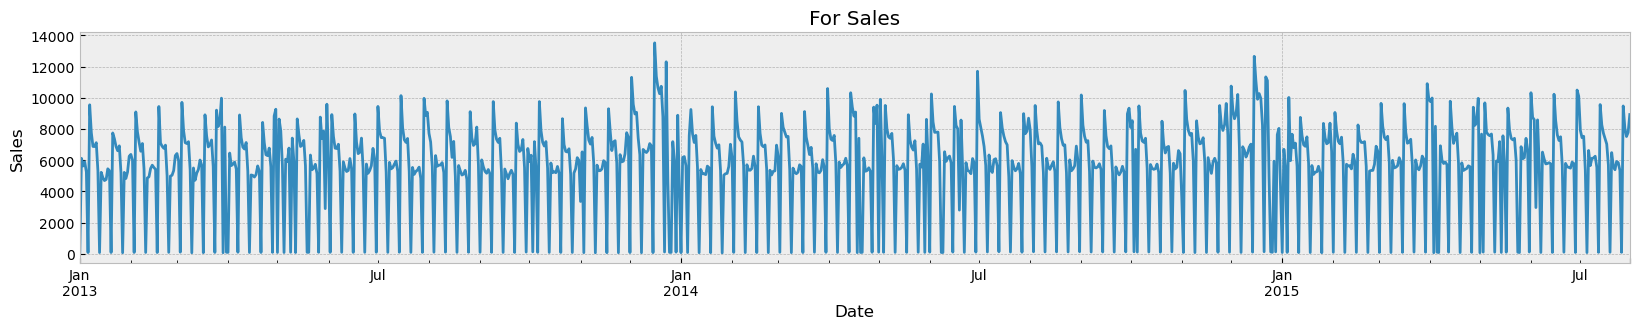

In [49]:
# Plotting time series chart for Sales
timeseries_plot(merged_df_all['Sales'],'Sales')

Creating function for seasonal decomposition

In [50]:
def plot_seasonal_decomposition(series,c,model):
    rcParams['figure.figsize'] = 18, 14
    decomposition = sm.tsa.seasonal_decompose(series, model=model) # additive seasonal index
    fig = decomposition.plot()
    plt.show()
    print('Mean Residual for {}={}'.format(c,decomposition.resid.mean()))

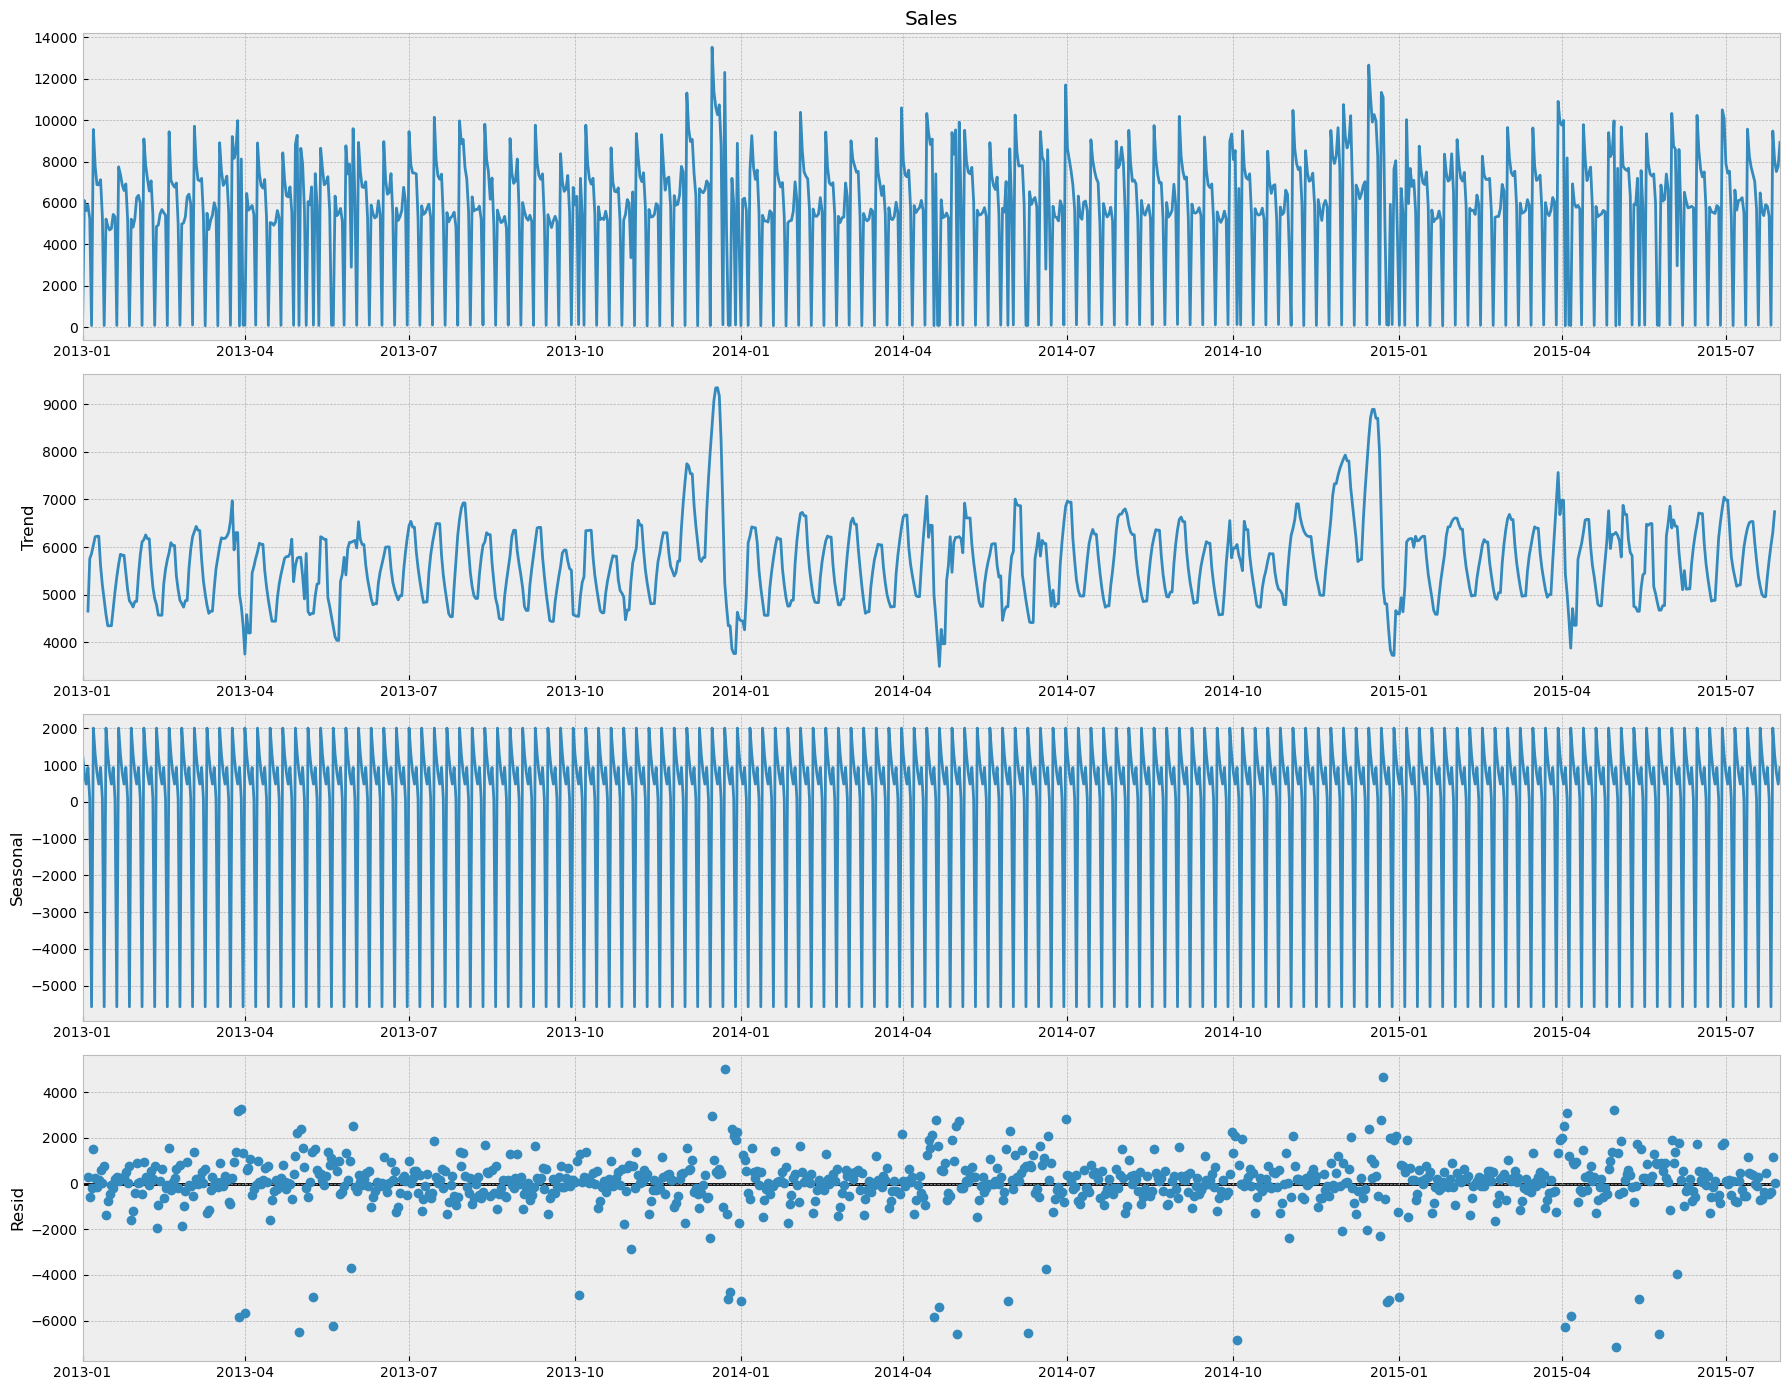

Mean Residual for Sales=0.6320934875517777


In [51]:
plot_seasonal_decomposition(merged_df_all['Sales'],'Sales','additive')

# 8) Causalty testing

In [52]:
causalty_sales = grangercausalitytests(merged_df_all[['Sales','Customers']].dropna(),4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=208.3792, p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=209.0457, p=0.0000  , df=1
likelihood ratio test: chi2=188.7776, p=0.0000  , df=1
parameter F test:         F=208.3792, p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=116.0667, p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=233.3748, p=0.0000  , df=2
likelihood ratio test: chi2=208.4539, p=0.0000  , df=2
parameter F test:         F=116.0667, p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=84.4063 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=255.1208, p=0.0000  , df=3
likelihood ratio test: chi2=225.6887, p=0.0000  , df=3
parameter F test:         F=84.4063 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=71.6356 , p=0.0000  

The test indicates casuality between Sales and Customers

# 9) Stationarity Test

#### Creating a function for testing stationary using ADF statistic

In [53]:
def adf_statistics(df):
    for c in df.columns:
        print('For ',c)
        print('-'*100)
        adf_test = adfuller(df[c],autolag='AIC')
        print('ADF Statistic: %f' % adf_test[0])
        print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
        output = {'test_statistic':round(adf_test[0], 4), 'pvalue':round(adf_test[1], 4), 'n_lags':round(adf_test[2], 4), 'n_obs':adf_test[3]}
        p_value = output['pvalue']        
        if p_value <= 0.05:
            print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
            print(f" => Series is Stationary.")
        else:
            print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
            print(f" => Series is Non-Stationary.")  

In [54]:
adf_statistics(merged_df_all[['Sales','Customers']])

For  Sales
----------------------------------------------------------------------------------------------------
ADF Statistic: -5.705442
Critical Values @ 0.05: -2.86
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
For  Customers
----------------------------------------------------------------------------------------------------
ADF Statistic: -6.058044
Critical Values @ 0.05: -2.86
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


The p-values for both the variables is less than 0.05. We can reject the null hypothesis. The series is stationary

In the dataset, we do not have any other variable which is linearly related to Sales. They do not seem to be time series inputs for our analysis.

We had earlier determined that since increase in customers relate to increased sales and since no other variable is a time series, we will consider them to be exogenous. 

# 10) Autocorrelation

Creating functions for ACF and PACF plot

In [59]:
def acf_plot(series,c):
    plot_acf(series,lags = 70)
    plt.title('ACF for {}'.format(c)) 
    plt.show()
def pacf_plot(series,c):
    plot_pacf(series, lags = 70)
    plt.title('PACF for {}'.format(c)) 
    plt.show()

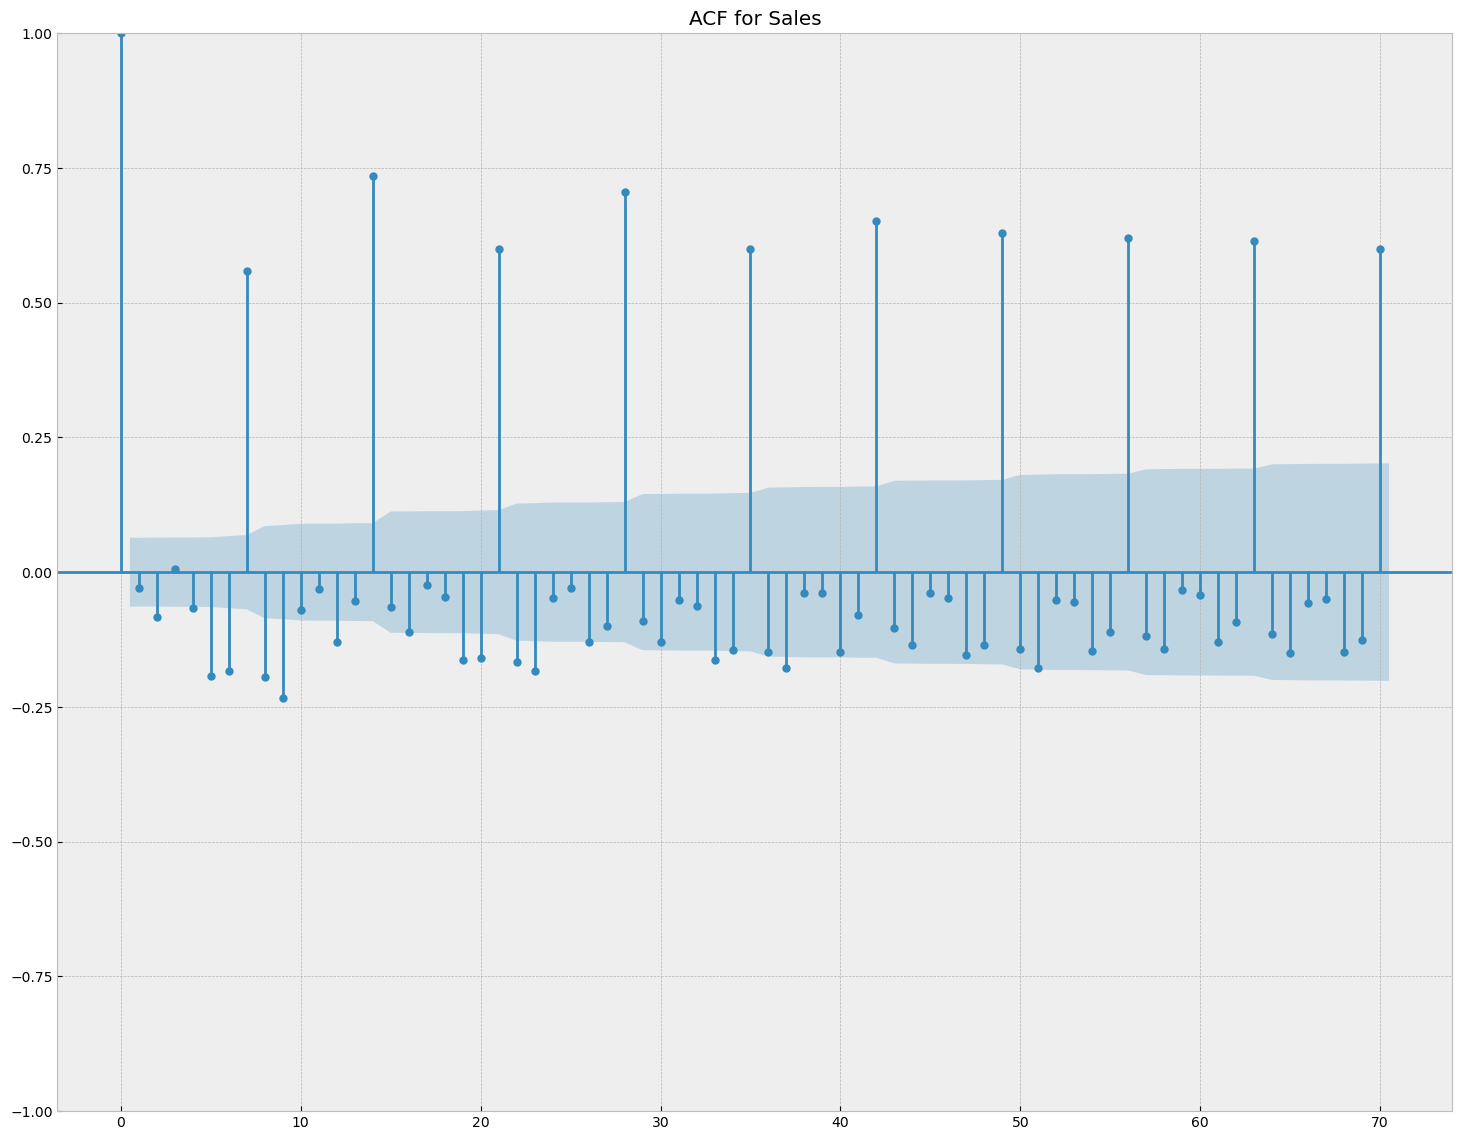

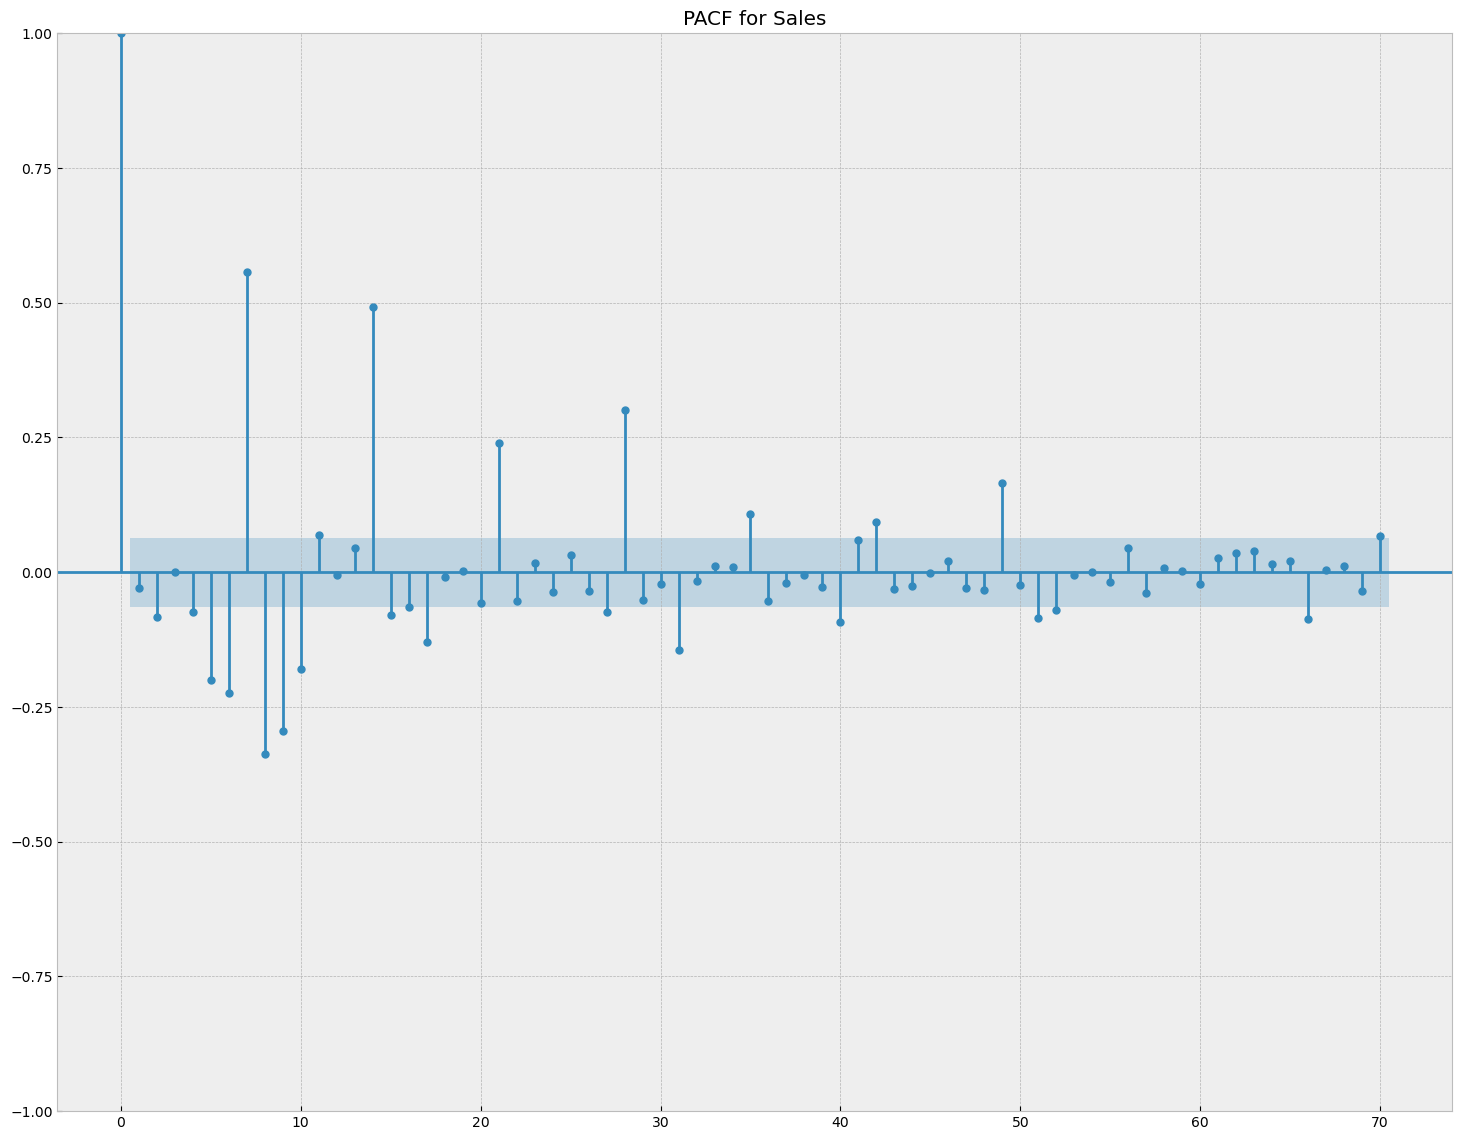

In [60]:
acf_plot(merged_df_all['Sales'],'Sales')
pacf_plot(merged_df_all['Sales'],'Sales')

For ACF, we set q=0 as co-realation never comes dowm. For PACF, we set p=7, since it is the highest lag since inception.

# 11) Train Test Split

Standardising numerical values in test-train datasets using minmax

In [61]:
# Fit transform on train data
scaler = MinMaxScaler()
merged_df_all[['Sales','Customers','Promo','SchoolHoliday']]=scaler.fit_transform(merged_df_all[['Sales','Customers','Promo','SchoolHoliday']])
merged_df_all.head()

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,
2013-01-01,0.000000,0.000720,0.0,0.998185,1.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,0.450247,0.567996,0.0,0.990018,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03,0.413935,0.523533,0.0,0.928312,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-04,0.433070,0.536808,0.0,0.926497,0.0,0.0,0.0,1.0,0.0,0.0
2013-01-05,0.385556,0.467650,0.0,0.101633,0.0,0.0,0.0,0.0,1.0,0.0


We need to predict sales for the next 6 weeks i.e 42 days. So, we keep 42 days for test and remaining for training

In [62]:
merged_df_all.shape

(942, 10)

In [63]:
# splitting the merged dataset into train and test dataset
train_len = 900
train = merged_df_all.iloc[:train_len]
test = merged_df_all.iloc[train_len:]

In [64]:
# checking the shape of train and test dataset
print(train.shape)
print(test.shape)

(900, 10)
(42, 10)


# 12) Predictive Modelling

### 12.1) VAR (Vector Autoregressive Model)

In [65]:
exog = train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train[['Sales', 'Customers']].astype(float)
var_model = sm.tsa.VAR(endog,exog)
res=var_model.select_order(maxlags=20)
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -11.95      -11.85   6.483e-06      -11.91
1       -12.07      -11.95   5.706e-06      -12.03
2       -12.07      -11.93   5.715e-06      -12.02
3       -12.11      -11.95   5.509e-06      -12.05
4       -12.12      -11.93   5.473e-06      -12.05
5       -12.12      -11.91   5.472e-06      -12.04
6       -12.12      -11.90   5.432e-06      -12.04
7       -12.12      -11.87   5.424e-06      -12.03
8       -12.27      -11.99   4.708e-06      -12.16
9       -12.30     -12.01*   4.552e-06      -12.19
10      -12.32      -12.00   4.479e-06      -12.20
11      -12.33      -12.00   4.399e-06      -12.21
12      -12.33      -11.97   4.429e-06      -12.19
13      -12.34      -11.95   4.395e-06      -12.19
14      -12.38      -11.98   4.204e-06     -12.23*
15     -12.39*      -11.96  4.171e-06*      -12.23
16      -12.38      -11.94   4.

AIC is lowest at lag 15

In [66]:
# fitting the model with lag 15
var_model_final = var_model.fit(15)
var_model_final.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Jun, 2024
Time:                     21:10:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.9770
Nobs:                     885.000    HQIC:                  -12.2375
Log likelihood:           3052.95    FPE:                4.12402e-06
AIC:                     -12.3988    Det(Omega_mle):     3.78323e-06
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.327392         0.067519            4.849           0.000
Promo                 0.165843         0.016943            9.788           0.000
SchoolHoliday        -0.047503         0.013511           -3

Perform Johansen test with p=10

# 12.2) Cointegration - Johansen Test

Creating a function for Johansen test for checking cointegration

In [67]:
def cointegration_test(df, lag): 
    alpha=0.05
    out = coint_johansen(df,-1,lag)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [68]:
merged_df_all['Sales'] = merged_df_all['Sales'].apply(lambda x : round(x))
merged_df_all['Customers'] = merged_df_all['Customers'].apply(lambda x : round(x))

In [69]:
cointegration_test(merged_df_all[['Sales','Customers']],10)
rank_result = select_coint_rank(merged_df_all[['Sales','Customers']],-1,15) 
print(rank_result)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Sales  ::  126.1     > 12.3212   =>   True
Customers ::  2.09      > 4.1296    =>   False
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          75.29          12.32
  1   2         0.6079          4.130
-------------------------------------


We have the rank of Johansen test as 2 which means that the time series are stationary but do not seem to be co-integratied

In [70]:
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [71]:
joh_model1 = coint_johansen(merged_df_all[['Sales','Customers']],-1,15) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0     74.686379   75.294317
1      0.607938    0.607938 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [72]:
# Getting lag order
lag_order = var_model_final.k_ar
print(lag_order) 
forecast_input = train[['Sales','Customers']].values[-lag_order:]
forecast_input

15


array([[0.63325079, 0.66316554],
       [0.4212333 , 0.48537264],
       [0.00203833, 0.00207856],
       [0.47988089, 0.56603356],
       [0.44716117, 0.53181677],
       [0.42366799, 0.50996691],
       [0.42568644, 0.51951432],
       [0.42946949, 0.51526733],
       [0.42403172, 0.4795486 ],
       [0.00218823, 0.0019645 ],
       [0.75547901, 0.72109848],
       [0.63025527, 0.64123037],
       [0.56222237, 0.59152311],
       [0.53517805, 0.57322756],
       [0.55275525, 0.59377851]])

# 12.3) Forecasting using VAR

In [73]:
exog_test = test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
fc = var_model_final.forecast(y=forecast_input, steps=42,exog_future=exog_test)
var_forecast = pd.DataFrame(fc, index=test.index, columns=['Sales','Customers'])
var_forecast

,Sales,Customers
Date,,
2015-06-20,0.442158,0.513312
2015-06-21,0.002729,-0.001764
2015-06-22,0.444813,0.534939
2015-06-23,0.440654,0.542027
2015-06-24,0.400568,0.493723
2015-06-25,0.353214,0.444748
2015-06-26,0.440353,0.533645
2015-06-27,0.430370,0.499625
2015-06-28,-0.004850,-0.008593


In [74]:
#Adding forecasted values
test['VarForecastedSales']=var_forecast.Sales
test['VarForecastedCustomers']=var_forecast.Customers

Creating function for visualisation

In [75]:
def forecasted_timeseries_visualization(series,forecasted_series,c,model):
    fig = plt.figure(figsize=(20, 3))
    series.plot(label='Actual')
    forecasted_series.plot(label='Forecasted')
    plt.xlabel('Date')
    plt.ylabel(c)
    plt.legend(loc='best')
    plt.title('{} model For {}'.format(model,c))
    plt.show()

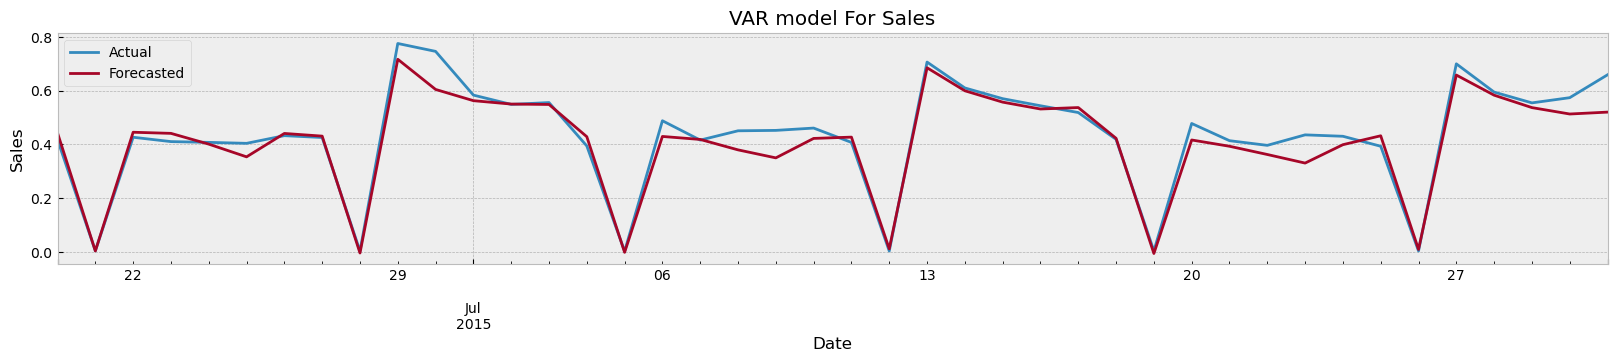

In [76]:
# Visualising actual and forecasted sales
forecasted_timeseries_visualization(test['Sales'],test['VarForecastedSales'],'Sales','VAR')

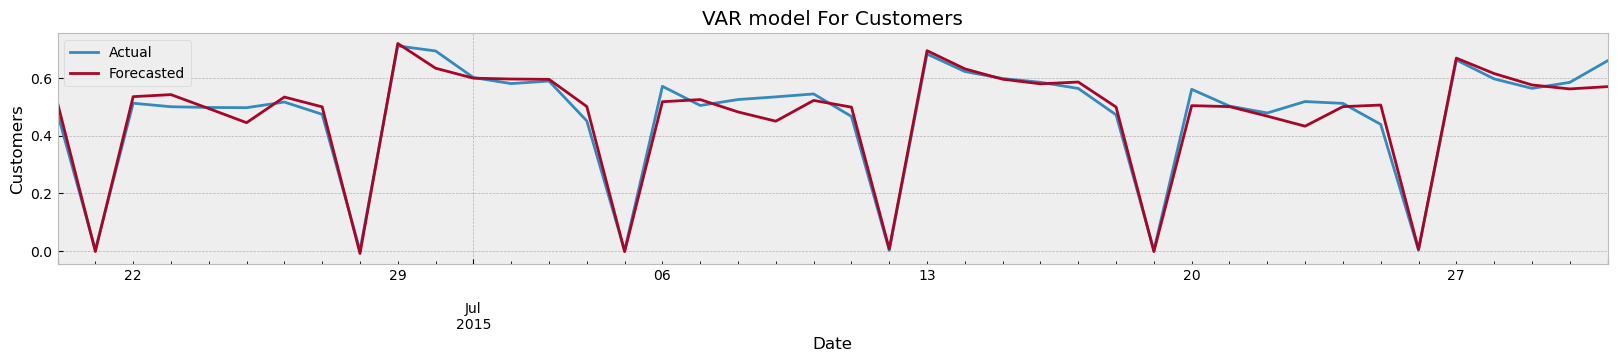

In [77]:
# Visualising actual and forecasted customers
forecasted_timeseries_visualization(test['Customers'],test['VarForecastedCustomers'],'Customers','VAR')

## 12.4) Model Evaluation

Defining a function to evaluate model using MAPE

In [78]:
def model_eval(df,pred_sales,pred_customers, model_name):
    abs_error = np.abs(df.Sales- pred_sales)
    actual = df.Sales
    mape = np.round(np.mean(abs_error/actual)*100, 2)
    
    result = pd.DataFrame({'Model':model_name,'Variable':['Sales'],'MAPE':[mape]})
    
    abs_error_1 = np.abs(df.Customers-pred_customers)
    actual_1 = df.Customers
    mape_1 = np.round(np.mean(abs_error_1/actual_1)*100, 2)
    
    result_1 = pd.DataFrame({'Model':model_name,'Variable':['Customers'],'MAPE':[mape_1]})

    result= pd.concat([result,result_1])

    return result

In [79]:
# Evaluating VAR model
mod_eval = model_eval(test,test['VarForecastedSales'],test['VarForecastedCustomers'],'VAR')
mod_eval

,Model,Variable,MAPE
0,VAR,Sales,41.33
0,VAR,Customers,39.71


# 12.5) Forecasting using VARMAX

We had used q=0 and p=7 for VAR

In [80]:
#modelling
exog = train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train[['Sales', 'Customers']].astype(float)
varmax_model = sm.tsa.VARMAX(endog, order=(7,0),  exog=exog)
varmax_model_fit = varmax_model.fit(maxiter=1000, disp=False)
print(varmax_model_fit.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood                2945.902
                              + intercept   AIC                          -5793.805
Date:                    Tue, 25 Jun 2024   BIC                          -5558.487
Time:                            21:11:56   HQIC                         -5703.912
Sample:                        01-01-2013                                         
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            1.04, 34.76   Jarque-Bera (JB):     6130.43, 1939.27
Prob(Q):                        0.31, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.62, 1.48   Skew:                     -1.94, -1.51
P

In [81]:
#forecasting on test data

exog_test = test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog_test= test[['Sales','Customers']]
varmax_fc = varmax_model_fit.predict(start = test.index.min(), end = test.index.max(),exog=exog_test)
varmax_forecast = pd.DataFrame(varmax_fc, index=test.index, columns=['Sales','Customers'])
varmax_forecast.head()

,Sales,Customers
Date,,
2015-06-20,0.453216,0.523358
2015-06-21,0.005680,0.000293
2015-06-22,0.475589,0.552988
2015-06-23,0.417575,0.523080
2015-06-24,0.377050,0.486201


In [82]:
#Adding forecasted values

test['VarmaxForecastedSales']=varmax_forecast.Sales
test['VarmaxForecastedCustomers']=varmax_forecast.Customers

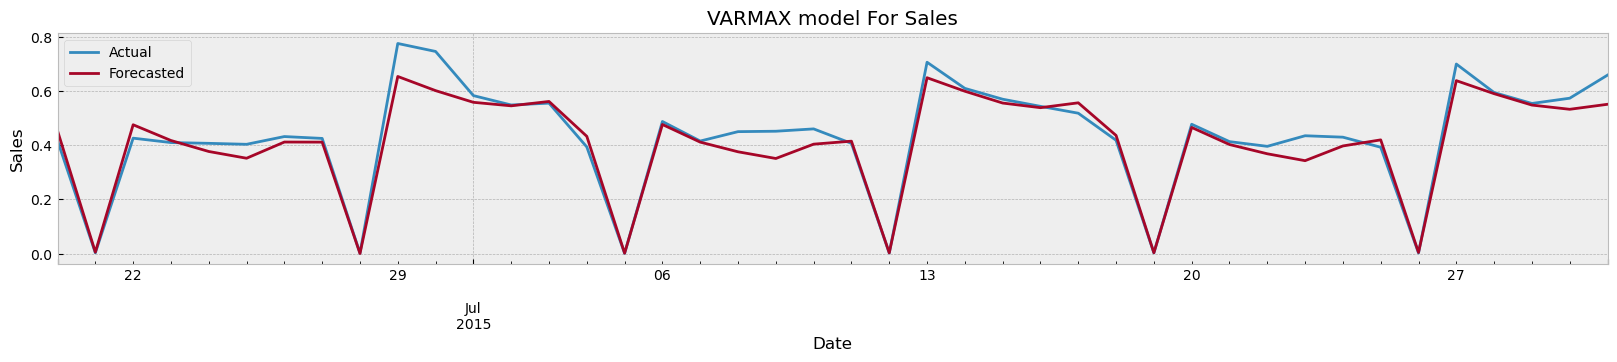

In [83]:
# Visualising actual and forecasted sales
forecasted_timeseries_visualization(test['Sales'],test['VarmaxForecastedSales'],'Sales','VARMAX')

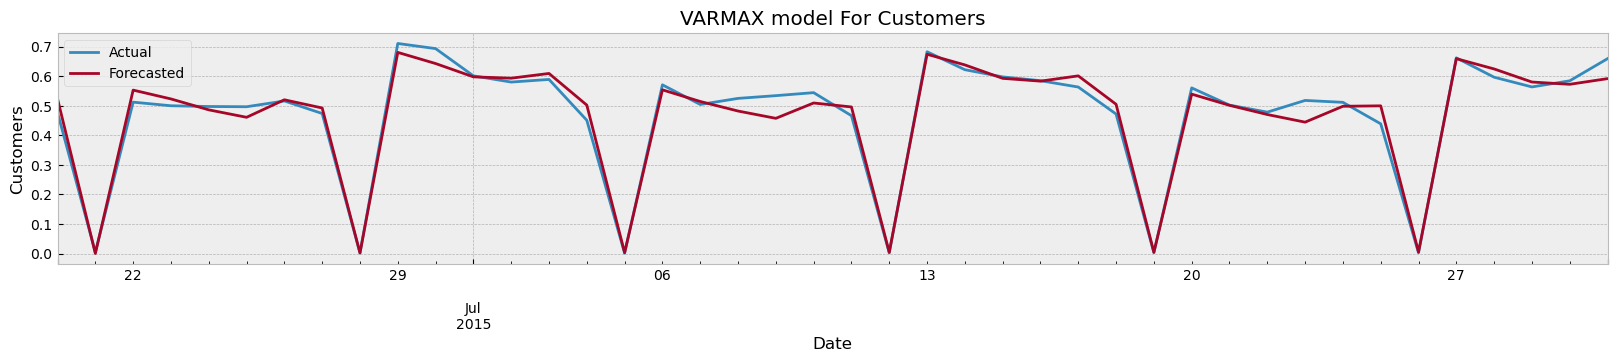

In [84]:
# Visualising actual and forecasted customers
forecasted_timeseries_visualization(test['Customers'],test['VarmaxForecastedCustomers'],'Customers','VARMAX')

## 12.6) Model Evalutaion

In [85]:
# Evaluating VARMAX model and combining results of VAR and VARMAX model
mod_eval_1 = model_eval(test,test['VarmaxForecastedSales'],test['VarmaxForecastedCustomers'],'VARMAX')
mod_eval = pd.concat([mod_eval,mod_eval_1])
mod_eval.reset_index(drop=True,inplace=True)
mod_eval

,Model,Variable,MAPE
0,VAR,Sales,41.33
1,VAR,Customers,39.71
2,VARMAX,Sales,13.08
3,VARMAX,Customers,16.42


# 13) Conclusion

- We can observe that on transitioning from VAR model to VARMAX model, if we look at MAPE, there is significant improvement in the forecasting accuracy for VARMAX.
- Both the models have really less difference in MAPE for Sales and Customers attribute but VARMAX accuracy for both attribute is much better than VAR.
- Hence, we will be moving forward with the VARMAX forecast values for the next 6 weeks for the sales figure of the stores.